In [1]:
# import the Torch package to save your day
# transforms are used to preprocess the images, e.g. crop, rotate, normalize, etc
import torch
from torchvision import datasets,transforms

# specific the data path in which you would like to store the downloaded files
# here, we save it to the folder called "mnist_data"
# ToTensor() here is used to convert data type to tensor, so that can be used in network

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

print(train_dataset)

batchSize=128

#only after packed in DataLoader, can we feed the data into the neural network iteratively
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 138307245.56it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21724478.81it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49766787.54it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3704886.96it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: ToTensor()


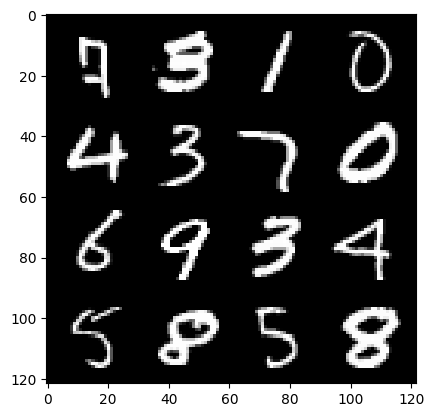

In [2]:
# package we used to manipulate matrix
import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2st layer num features
num_hidden_3 = 64  # 3st layer num features
num_hidden_4 = 32 # 4nd layer num features
num_hidden_5 = 16 # 4nd layer num features (the latent dim)

num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(28, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 28,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(28, 1,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initialzing, it will run __init__() function as above
model = Autoencoder()
# If using GPU, model need to be set on cuda()
model.cuda()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(28, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(28, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [13]:
# define loss and parameters
optimizer = torch.optim.Adam(model.parameters())
epoch = 200
# MSE loss will calculate Mean Squared Error between the inputs
loss_function = nn.MSELoss()

print('====Training start====')
for i in range(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # prepare input data
        data = data.cuda()
        inputs = data
        # set gradient to zero
        optimizer.zero_grad()

        # feed inputs into model
        recon_x = model(inputs)

        # calculating loss
        loss = loss_function(recon_x, inputs)

        # calculate gradient of each parameter
        loss.backward()
        train_loss += loss.item()

        # update the weight based on the gradient calculated
        optimizer.step()

    if i%10==0:
        print('====> Epoch: {} Average loss: {:.9f}'.format(i, train_loss ))
print('====Training finish====')

====Training start====
====> Epoch: 0 Average loss: 22.575386160
====> Epoch: 10 Average loss: 2.478868367
====> Epoch: 20 Average loss: 2.057642289
====> Epoch: 30 Average loss: 1.801043735
====> Epoch: 40 Average loss: 1.669373604
====> Epoch: 50 Average loss: 1.589916337
====> Epoch: 60 Average loss: 1.534244169
====> Epoch: 70 Average loss: 1.496350491
====> Epoch: 80 Average loss: 1.464919562
====> Epoch: 90 Average loss: 1.440302107
====> Epoch: 100 Average loss: 1.419432746
====> Epoch: 110 Average loss: 1.401963844
====> Epoch: 120 Average loss: 1.387168333
====> Epoch: 130 Average loss: 1.375248785
====> Epoch: 140 Average loss: 1.363613114
====> Epoch: 150 Average loss: 1.353031098
====> Epoch: 160 Average loss: 1.342063926
====> Epoch: 170 Average loss: 1.329899305
====> Epoch: 180 Average loss: 1.316827758
====> Epoch: 190 Average loss: 1.308227725
====Training finish====


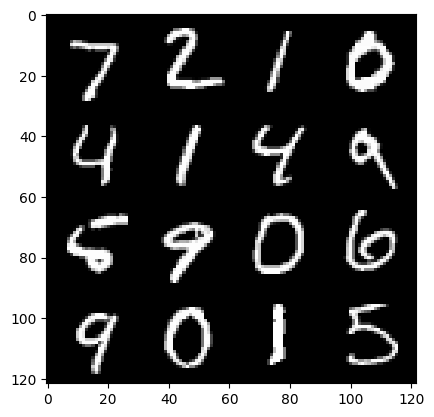

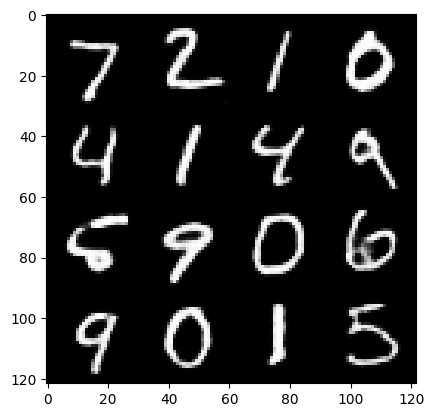

In [15]:
# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=inputs.cuda()
# inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=model(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)